# Download AQS data for model comparison

**Author:** Michael Needham, US EPA Region 7 Air and Radiation Division

**Contact:** needham.michael@epa.gov

**Description:** Auxiliary example showing how to download AQS data that coincides with CMAQ output using __[pyRSIG](https://github.com/barronh/pyrsig)__. Also includes an example of plotting AQS monitor data on an interactive web map with __[folium](https://python-visualization.github.io/folium/latest/#)__.

In [1]:
import folium
from pyrsig import RsigApi
from pathlib import Path
import pandas as pd
import xarray as xr
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import matplotlib as mpl
import matplotlib.pyplot as plt

ERROR 1: PROJ: proj_create_from_database: Open of /work/REGIONS/users/mneedham/.miniforge3/envs/cmaq_pyenv/share/proj failed


## 1. Data I/O

First, open the desired netcdf file to get the date range

In [2]:
file = Path("./tutorial_data/DDM_2022_36US3.011.HR2DAY.2022120-2022217.nc")

dset = xr.open_dataset(file)

bdate=pd.to_datetime(dset.time[0].data)
edate=pd.to_datetime(dset.time[-1].data)

print(f"Date Range: {bdate} to {edate}")

Date Range: 2022-04-30 00:00:00 to 2022-08-05 00:00:00


## 2. Data download with pyRSIG

### 2.A Visualize the bounding box with folium

To visualize the bounding box that will be used for our data request, we can first generate a simple interactive map and add our bounding box using __[folium.Rectangle](https://python-visualization.github.io/folium/latest/user_guide/vector_layers/rectangle.html#Rectangle)__. This allows for an easy iterative process to specify the correct bounding box

In [3]:
# x0, x1, y0, y1 coordinates of the bounding box in longitude / latitude
# Change these as needed!

x0 = -98
x1 = -85
y0 =  36
y1 =  44

# ----- Folium map in just two lines of code! -------------------------------
bbox_map = folium.Map(location=[39.0997,-94.5786],zoom_start=4)

# Note the ordering of the bounds variable is latitude ~then~ longitude
# because of web mercator conventions
folium.Rectangle(bounds=[(y0,x0),(y1,x1)]).add_to(bbox_map)

# Display the map:
bbox_map

### 2.B Request AQS data using pyRSIG

Use the __[pyrsig.RsigApi](https://barronh.github.io/pyrsig/pyrsig.html#pyrsig.RsigApi)__ interface, which allows the user to specify a bounding box (`bbox`), beginning and ending dates (`bdate`, `edate`) and a working director (`workdir`) which will be used to cache our data.

Ultimately we will call `rsigapi.to_dataframe` with a specific data key. The list of all available RSIG keys can be retrieved after the RsigApi instance is created with (e.g.,)

```python
rsigapi = RsigApi(
    ...
)

keys = rsigapi.keys()
print(keys)
```

For this example, we will use `aqs.ozone_daily_8hour_maximum` as our key.

In [4]:
bbox = [x0,y0,x1,y1]
key = 'aqs.ozone_daily_8hour_maximum'

# Initialize the RsigApi object
rsigapi = RsigApi(
    bbox=bbox,
    bdate=bdate,
    edate=edate,
    workdir="./tutorial_data/" # <--- Cached data will be stored here
)

# Perform the request
aqs_mda8o3 = rsigapi.to_dataframe(key=key)

# Also, drop any NaN values
aqs_mda8o3 = aqs_mda8o3[~np.isnan(aqs_mda8o3['ozone_daily_8hour_maximum(ppb)'])]

aqs_mda8o3.head()

Using cached: ./tutorial_data//aqs.ozone_daily_8hour_maximum_2022-04-30T000000Z_2022-08-05T000000Z.csv.gz


,Timestamp(UTC),LONGITUDE(deg),LATITUDE(deg),STATION(-),ozone_daily_8hour_maximum(ppb),SITE_NAME
0,2022-04-30T00:00:00-0000,-94.1168,36.1797,51430005,45.0,Springdale
1,2022-04-30T00:00:00-0000,-94.1674,36.0117,51430006,47.0,Fayetteville
2,2022-04-30T00:00:00-0000,-91.3359,39.9154,170010007,52.0,Quincy
3,2022-04-30T00:00:00-0000,-88.1885,40.2449,170190007,43.0,Thomasboro
4,2022-04-30T00:00:00-0000,-88.3725,40.0528,170191001,41.0,Bondville


## 3. Make a quick plot

Now, we can use this data to generate a scatter plot. This could be done with matplotlob, but since we have already used folium, here's an example of how to generate a basic interactive plot.

First, we need to select the day for our plot. One intersting day would be the day in which the largest number of AQS monitors exceeded the NAAQS of 0.070 ppm (70 ppb). We can identify that day as follows:

In [5]:

# Add an additional True/False column to aqs_mda8o3 flagging if the monitor
# exceeded the NAAQS on that day
aqs_mda8o3['EXCD'] = aqs_mda8o3['ozone_daily_8hour_maximum(ppb)'] > 70.9

aqs_mda8o3.head()

,Timestamp(UTC),LONGITUDE(deg),LATITUDE(deg),STATION(-),ozone_daily_8hour_maximum(ppb),SITE_NAME,EXCD
0,2022-04-30T00:00:00-0000,-94.1168,36.1797,51430005,45.0,Springdale,False
1,2022-04-30T00:00:00-0000,-94.1674,36.0117,51430006,47.0,Fayetteville,False
2,2022-04-30T00:00:00-0000,-91.3359,39.9154,170010007,52.0,Quincy,False
3,2022-04-30T00:00:00-0000,-88.1885,40.2449,170190007,43.0,Thomasboro,False
4,2022-04-30T00:00:00-0000,-88.3725,40.0528,170191001,41.0,Bondville,False


Then, we need to find the date with the largest number of exceedances. This two-step process involves first counting the number of monitors that exceeded on each day, and then finding the day with the largest number of exceedances. We will use the __[pandas.DataFrame.groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html)__ method. 

This method says to separate rows into groups *by some value*... here, our grouping is `by=Timestamp`. Essentially, make groups where each member within a groupb has the same timestamp. Once the rows are grouped we then need to aggregate the members together using the sum function (other options could include mean, max, min, std, etc.). For more information, see __[Group by: split-apply-combine](https://pandas.pydata.org/docs/user_guide/groupby.html)__ in the pandas documentation.

In [7]:
n_excd = aqs_mda8o3.groupby(by=aqs_mda8o3['Timestamp(UTC)'])['EXCD'].sum()

timestamp = n_excd[n_excd==n_excd.max()].index[0]

timestamp

'2022-06-20T00:00:00-0000'

From here, it is just a simple matter of indexing the desired timestep.

In [8]:
# Pick the day with the greatest number of MDA8O3 exceedances
single_day = aqs_mda8o3[aqs_mda8o3["Timestamp(UTC)"]==timestamp]

single_day.head()

,Timestamp(UTC),LONGITUDE(deg),LATITUDE(deg),STATION(-),ozone_daily_8hour_maximum(ppb),SITE_NAME,EXCD
9333,2022-06-20T00:00:00-0000,-94.1168,36.1797,51430005,44.0,Springdale,False
9334,2022-06-20T00:00:00-0000,-94.1674,36.0117,51430006,31.0,Fayetteville,False
9335,2022-06-20T00:00:00-0000,-91.3359,39.9154,170010007,61.0,Quincy,False
9336,2022-06-20T00:00:00-0000,-88.1885,40.2449,170190007,74.0,Thomasboro,True
9337,2022-06-20T00:00:00-0000,-88.3725,40.0528,170191001,78.0,Bondville,True


### 3.A Custom Colormap

This is the same colormap we generated in __[Example 2](./02_hr2day_output_analysis_example.ipynb)__. However, folium wants the colors for points as [Hexadecimal Web colors](https://en.wikipedia.org/wiki/Web_colors) instead of RGB, so we will need to write a function to do that conversion.

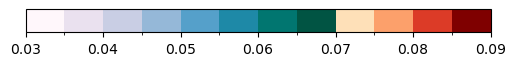

In [9]:
from matplotlib.colors import ListedColormap

# Setup the range for the desired colorbar
vmin = 0.030
vmax = 0.090
dlev = 0.005
levels = np.arange(vmin,vmax+dlev/2,dlev)


# Resample the colorbars so that cmap1 has twice as many colors as cmap2. This
# fraction will make it easy to align the limits so that the break between the
# two colorbars occurs right at the deisred 0.070 ppb threshold
cmap1 = mpl.colormaps['PuBuGn'].resampled(256)
cmap2 = mpl.colormaps['OrRd'].resampled(128)

# Generate a list of colors from the two existing cmaps in the desired order, 
# from which we will generate the new colormap
clist = []
for n in range(cmap1.N):
    rgb = cmap1(n)
    clist.append(rgb)
    
for n in range(cmap2.N):
    rgb = cmap2(n)
    clist.append(rgb)
    
# Generate the new colorbar based on the colorbar list
cmap = ListedColormap(clist,name='ozone')
norm = mpl.colors.BoundaryNorm(ncolors=cmap.N,boundaries=levels)
smap = mpl.cm.ScalarMappable(cmap=cmap,norm=norm)

cmap.set_under('w') # <- all values below our vmin will be mapped to white

# These two lines are just included to dispaly the colorbar
fig, ax = plt.subplots(figsize=(6,0.3))
fig.colorbar(smap,cax=ax,orientation='horizontal') 

In [10]:
def rgb2hex(color_rgb,is_rgb255 = False):
    """Convert a color in [R, G, B] to hex"""

    color_rgb = np.array(color_rgb)

    if len(color_rgb) > 3:
        color_rgb = color_rgb[:3]

    if not is_rgb255:
        # Multiply by 255 and round to the nearest integer if the colors are
        # natively in RGB 0-1 color space
        color_rgb = [int(x) for x in 255 * np.array(color_rgb)]

    # Use f string formatting to generate the color string in Hex format
    r,g,b = color_rgb
    color = f"#{r:02x}{g:02x}{b:02x}"

    return color

Iterate through each row of the `single_day` DataFrame and add to the folium map as a __[folium.CircleMarker](https://python-visualization.github.io/folium/latest/user_guide/vector_layers/circle_and_circle_marker.html)__

In [12]:
pt_map = folium.Map(location=[39.0997,-94.5786],zoom_start=5)
folium.Rectangle(bounds=[(y0,x0),(y1,x1)],color='black').add_to(pt_map)

for _, pt in single_day.iterrows():

    # Parse the row to get values
    lon = float(pt['LONGITUDE(deg)'])
    lat =  float(pt['LATITUDE(deg)'])
    val = float(pt['ozone_daily_8hour_maximum(ppb)'])
    station = str(pt['STATION(-)'])
    site = str(pt['SITE_NAME'])

    # Colormap is based on 0-0.09 ppm but data is in ppb, so divide by 1000...
    # then normalizing data... and only then pass to the colormap.
    color_rgb = cmap(norm(val / 1000))
    color_hex = rgb2hex(color_rgb)
    
    folium.CircleMarker(
        location=(lat,lon),
        color='black',
        weight=1,
        fill_color=color_hex,            
        radius=8,
        tooltip=f"{val} ppb | {site} | {station}",
        fill=True,
        fill_opacity=1
    ).add_to(pt_map)

pt_map